# Deep neural network-based models for predicting mRNA editing in Trachurus trachurus 

Bidirectional LSTM with Attention Layer

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [2]:
########################################
# PARAMS
########################################
fname      = 'ttr_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv'
separator_char=';'
categories=[['A','G','C','T'],['s','d','h','i','b']]
padding=True
ptrain     = 0.7
trace_level = 1
model_name = 'TFM_LSTMBidiAttention_TT'
num_lstm_units=256
n_epochs=40
batch_size=32
categories_size=20
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [3]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Not running on CoLab


Checking if GPU is available and GPU characteristics.

In [4]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Sun Oct 16 16:45:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    N/A /  N/A |    498MiB /  2048MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [5]:
if padding==True:
    categories_size=21

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/ALL_TT/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_TT/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

In [6]:
from rnaed import DataGenerator,DataEncoding
encoding=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoding.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoding.print_LUT_TupleToInteger()
categories_size=encoding.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 2 /categories: [['A', 'G', 'C', 'T'], ['s', 'd', 'h', 'i', 'b']]
Number of codes=21
('A', 's') / 0
('A', 'd') / 1
('A', 'h') / 2
('A', 'i') / 3
('A', 'b') / 4
('G', 's') / 5
('G', 'd') / 6
('G', 'h') / 7
('G', 'i') / 8
('G', 'b') / 9
('C', 's') / 10
('C', 'd') / 11
('C', 'h') / 12
('C', 'i') / 13
('C', 'b') / 14
('T', 's') / 15
('T', 'd') / 16
('T', 'h') / 17
('T', 'i') / 18
('T', 'b') / 19
('*', '*') / 20
Number of codes or categories size: 21


In [7]:
#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

LAST MODEL FILE: ./SAVED_MODELS\TFM_LSTMBidiAttention_TT.h5
BEST MODEL FILE: ./SAVED_MODELS\best_model_TFM_LSTMBidiAttention_TT.h5


We read the data.

In [8]:
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=separator_char)
print("shape dataraw={}".format(dataraw.shape))

DATASET: ../../data/datasets/ALL_TT/W50\ttr_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv
shape dataraw=(283012, 104)


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [9]:
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']
print(X.head)

<bound method NDFrame.head of         P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P92  P93  P94  P95  P96  \
0        2  12  17  17   7  12  12  17   7    7  ...   15   10   15   10   15   
1       11   3  11  16   6  11  11   1  11   11  ...    2   17    6    6   11   
2        8  16   6  13  18  18   3  16  16   11  ...   16   11    1   11    1   
3       18  18   6  16   1  16   1  11  11    5  ...    2   17    7   17   17   
4       17  17  17   2   2   7  17   2  17    7  ...    5   10    0   10    0   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
283007  10  16   6  16  11  16  11  16  11   16  ...   11    1   15    0    6   
283008  11   1  16   5   6  11  16   6   1    1  ...   12   12    2    6   11   
283009   6   6  18  11  16  11  11   8   3    8  ...    2   12    2    2   17   
283010   1   1  11  11  16   6  16   3   8   13  ...   11   16   16   16   16   
283011  17   7   2   2  17   2   2   7   7    2  ...    2   17    2    2    6  

In [10]:
# Train and Validation+Test
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=random_seed)

print("x_train:{} y_train:{}".format(x_train.shape,y_train.shape))
print("x_val: {} y_val: {}".format(x_val.shape,y_val.shape))
print("x_test: {} y_test: {}".format(x_test.shape,y_test.shape))
print("TRAIN LABELS:")
print(y_train.value_counts())
print("VALIDATION LABELS:")
print(y_val.value_counts())
print("TEST LABELS:")
print(y_test.value_counts())

x_train:(198108, 101) y_train:(198108,)
x_val: (42452, 101) y_val: (42452,)
x_test: (42452, 101) y_test: (42452,)
TRAIN LABELS:
1    99118
0    98990
Name: EDITING, dtype: int64
VALIDATION LABELS:
1    21271
0    21181
Name: EDITING, dtype: int64
TEST LABELS:
0    21335
1    21117
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [11]:
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator(x_test,  y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Attention Layer

In [12]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    ''' heredamos de la clase layer '''
    def __init__(self):
        super(attention,self).__init__()
    
    #En el método build definimos los pesos
    def build(self, input_shape):
        # Define the shape of the weights and bias in this layer
        # The layer has just 1 lonely neuron
        
        # For convenience sake, add a couple of properties
        self.num_dim_pernucleoside = input_shape[-1] ## 512 dimension del vector de contexto.
        self.nucleosides_persequence = input_shape[-2]  ## 101 número de timesteps de la secuencia
        num_units = 1
        
        
        #Weights shape=(512,1), recordemos que la red neuronal capa oculta tiene un peso por dimensión.
        self.W=self.add_weight(name="att_weight", shape=(self.num_dim_pernucleoside,num_units),
                               initializer="normal")
        #bias  shape=(101,1), hay un bias por cada timestep, palabra o nucleótido.
        self.b=self.add_weight(name="att_bias", shape=(self.nucleosides_persequence,num_units),
                               initializer="zeros")
        super(attention,self).build(input_shape)
    
    #en el método call definimos la lógica
    #esta es la implementación clásica
    def call_classic(self, x):
        # x is the input tensor of 2 x num_units = 512 dimensions
        """ We multiply the inputs ‘x’ of shape (101,512) by the layer weights ‘w’ 
        of shape (512 , 1) and obtain a (101,1) values (future attention weights). We add the bias (101,1) 
        and pass the output through any activation layer to form a neural network. So we now have 101 * 1 values and 
        We take a softmax of these values. Softmax squashes these into values in the 
        range between 0, and 1 whose sum is 1. These are the 101 attention weights. 
        We multiply each attention weight by the respective nucleoside hidden state and sum up and we are done. 
        We now have the ‘attention adjusted output’ state ready to be fed to the next dense layer for classification."""
        
        #e = K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)  # Necesario en algunos frameworks
        e = K.tanh(K.dot(x,self.W)+self.b) #Red neuronal densa de una neurona con una matriz de pesos W y un vector de bias
        a = K.softmax(e, axis=1) #hacemos softmax para normalizar y que los pesos sumen 1.
        # Multiplicamos cada hidden state por cada peso (101,512)*(101,1)=(101,512). 
        # No es matricial, sino componente a componente 
        output = x*a 
        #Sumamos los 101 hidden states y se obtiene un hidden state suma de dimensión (101,512)
        #También se retornan los pesos a (101,1)
        return a, K.sum(output, axis=1)
  
    #esta implementación es más robusta
    def call(self, x):
        """ Es lo mismo de antes pero más robusto a distintos frameworks"""
        e = K.tanh(K.dot(x,self.W)+self.b) # dimensiones (101,512)(512,1)+(101,1)=(101,1)
        e = Flatten()(e) #(?,101)
        a = Activation('softmax')(e) #(?,101)
        # Repite 512 veces los 101 pesos (?,101) = (?,512,101)
        temp = RepeatVector(self.num_dim_pernucleoside)(a)
        #Permuta (?,512,101) por (?,101,512) para poder multiplicar componente a 
        #componente después
        temp = Permute([2,1])(temp) 
        # Multiplicamnos por cada peso todas las componentes de todos los hidden states
        # hidden state X=(101,512) pesos=temp=(101,512)
        # el truco aquí es que cada fila de pesos es una repetición de 512 pesos iguales.
        output = Multiply()([x,temp])
        #Finalmente sumamos todas las filas y obtenemos así el hidden state ponderado
        output = Lambda(lambda values: K.sum(values, axis=1))(output)
        #Retornamos los pesos de atención y la suma de los hidden states.
        return a, output

## Model defined from the scratch

In [15]:
#MODELOS REDES NEURONALES LSTM CON CAPAS DE ATENCIÓN
# Import the libraries required in this example:

num_nucleosides = x_train.shape[1]
num_tokens = categories_size
print("Number of units={}".format(num_lstm_units))
#Definimos la estructura con el Functional model
inputs = keras.Input(shape=(num_nucleosides,num_tokens), name="INPUTS")
lstm_out   = layers.Bidirectional(layers.LSTM(num_lstm_units,return_sequences=True), name="LSTM_BI")(inputs)
dropout= layers.Dropout(0.2)(lstm_out)

#===============================
#METHOD 1: using a custom layer:
#===============================
#La salida de la capa bidireccional será de 1 batch=None numero de secuencias, 
#de 101 nucleosidos(timesteps=50+1+50) de 2 x número_unidades=2*256=512
#Es decir (None,101,512)
#---------uncomment here--------------------
#a ,att_d = attention()(dropout)
#-----------------------------
#La capa de atención debe retornarnos un peso para cada hidden state 
#correspondiente a cada elemento de la secuencia o timestep
#es decir, nos debe dar un peso por cada nucleósido, es decir, nos debe dar (101,1)
#Como son pesos probabilisticos deben sumar 1.
#Pero realmente no queremos esos pesos, sino la suma de los 101 hidden states 
#de dimensión 512 ponderados por esos pesos que es lo que conforma el verdadero contexto, 
# y que tendrá dimensión (None,1,512).
#Esta salida es lo que se llama el "attention adjusted output state".
#Para ello, nuestra capa de atención debe entrenar (101,1) pesos, ya que debemos 
#entrenar un peso por cada dimensión del espacio vectorial del contexto.
#Pero ojo, esos no son los pesos de la red neuronal de la capa de atención, porque si nuestra
#red neuronal de atención tuviera 101 pesos, serían posicionales y deben ser calculados por el 
#valor semántico de los nucleótidos (si fueran palabras por su significado, no por su posición)

#Nuestra red neuronal de atención debe atender al "significado" de las palabras, es decir,
#a la codificación de cada nucleótido en el vector de estados 
#de la LSTM que tiene dimensión 512. Por lo tanto el número de pesos de la  red de atención 
# es de (512,1). Son los pesos de las 512 conexiones de la neurona de esta capa.

#Durante el entrenamiento multiplicaremos matricialmente todos los nucleótidos de la 
#secuencia (101), con su codificación LSTMbidi(512), por los pesos de la capa de atención(512) y eso 
#nos dará los 101 pesos de atención:
#(101,512) x (512,1) = (101,1) los pesos de atención
#(512,1) son los pesos de la capa.

#Ahora entendemos por qué los pesos de atención no son constantes
#sino que para cada secuencia cambian:
#En una red ya entrenada:
#  (101,512)[variable] x (512,1)[constante] = (101,1)[variable]

#===============================================================

#===============================
#METHOD 2: using regular layers:
#===============================

#---------uncomment here--------------------
e=Dense(1, activation='tanh')(dropout) #Capa de atención
e=Flatten()(e)
a=Activation('softmax')(e) #Softmax para que sumen 1 los pesos de atención.
temp=RepeatVector(2*num_lstm_units)(a)
temp=Permute([2, 1])(temp)
# multiply weight with LSTM layer o/p
output = Multiply()([dropout, temp])
# Get the attention adjusted output state by adding up
att = Lambda(lambda values: K.sum(values, axis=1))(output)
#-----------------------------

#===============================================================
outputs= layers.Dense(1, activation='sigmoid', name="OUTPUT")(att)
#Creamos el modelo
model_from_scratch  = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

#Mostramos el modelo
print(model_from_scratch.summary())

Number of units=256
Model: "TFM_LSTMBidiAttention_TT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 101, 1)       513         ['dropout_2[0][0]']              
                                                       

In [16]:
#Compilation reset all weights
model_from_scratch.compile(optimizer=keras.optimizers.Adam(),
                           loss     =keras.losses.BinaryCrossentropy(),
                           metrics  =[keras.metrics.BinaryAccuracy()])

model=model_from_scratch

Recover last model, best model or generate a new model

In [17]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0


In [18]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

In [19]:
if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


In [20]:
if best_model_accuracy >= last_model_accuracy and best_model_accuracy != 0:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")


# Show the model architecture
model.summary()

Selected new untrained model
Model: "TFM_LSTMBidiAttention_TT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 101, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 101, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 101, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 101, 1)       513         ['dropout_2[0][0]']              
                                              

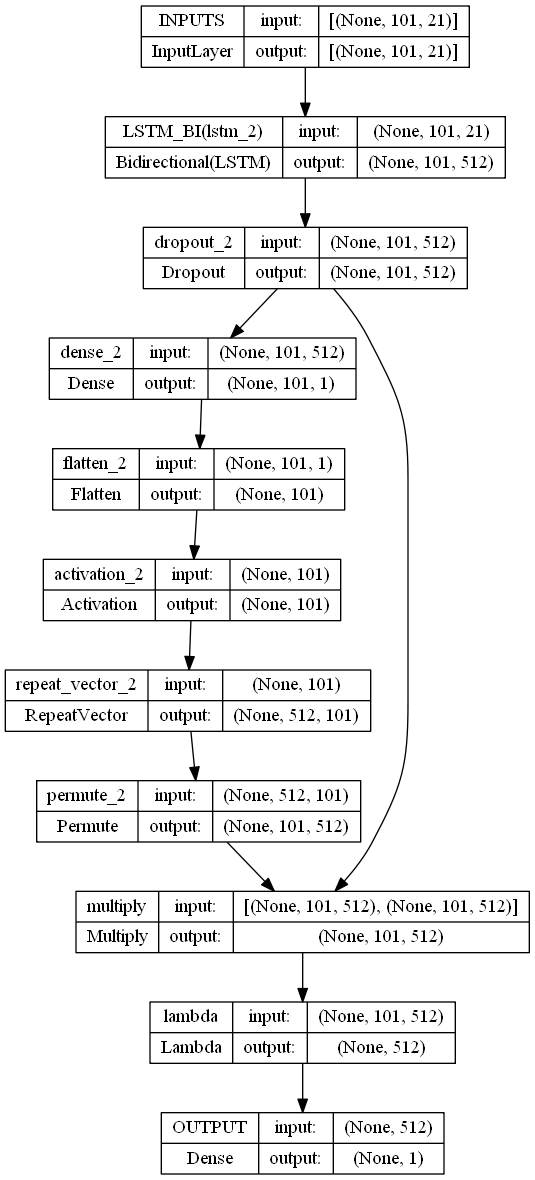

In [21]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [23]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=trace_level)

Epoch 1/40
6190/6190 [==============================] - ETA: 0s - loss: 0.6805 - binary_accuracy: 0.5651
Epoch 1: val_loss improved from inf to 0.67322, saving model to ./SAVED_MODELS\best_model_TFM_LSTMBidiAttention_TT.h5
6190/6190 [==============================] - 1065s 171ms/step - loss: 0.6805 - binary_accuracy: 0.5651 - val_loss: 0.6732 - val_binary_accuracy: 0.5806
Epoch 2/40
6190/6190 [==============================] - ETA: 0s - loss: 0.6647 - binary_accuracy: 0.5960
Epoch 2: val_loss improved from 0.67322 to 0.65558, saving model to ./SAVED_MODELS\best_model_TFM_LSTMBidiAttention_TT.h5
6190/6190 [==============================] - 1113s 180ms/step - loss: 0.6647 - binary_accuracy: 0.5960 - val_loss: 0.6556 - val_binary_accuracy: 0.6078
Epoch 3/40
6190/6190 [==============================] - ETA: 0s - loss: 0.6427 - binary_accuracy: 0.6280
Epoch 3: val_loss improved from 0.65558 to 0.62848, saving model to ./SAVED_MODELS\best_model_TFM_LSTMBidiAttention_TT.h5
6190/6190 [========

In [24]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 13 of 40


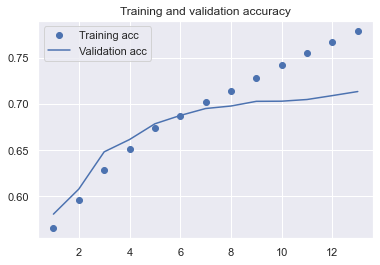

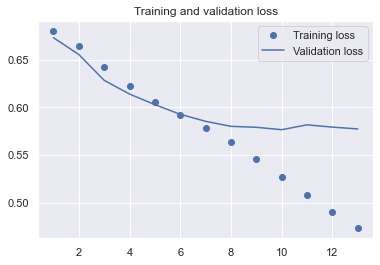

In [25]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [26]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [27]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
1326/1326 [==============================] - 176s 132ms/step - loss: 0.5767 - binary_accuracy: 0.7031
Accuracy on validation data: 0.703
Loss on validation data: 0.577


We make predictions on test data, never used during training nor validation

In [28]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
42452/42452 [==============================] - 610s 14ms/step


In [29]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(42452, 101)
(42452,)
(42452, 1)
(42452, 1)


In [30]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL TFM_LSTMBidiAttention_TT
---------------------------------
Kappa: 0.425
              precision    recall  f1-score   support

           0       0.70      0.75      0.72     21335
           1       0.73      0.67      0.70     21117

    accuracy                           0.71     42452
   macro avg       0.71      0.71      0.71     42452
weighted avg       0.71      0.71      0.71     42452



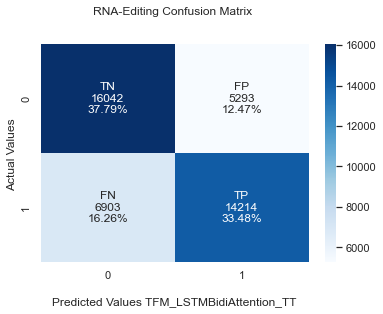

In [31]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()


AUC: 0.77


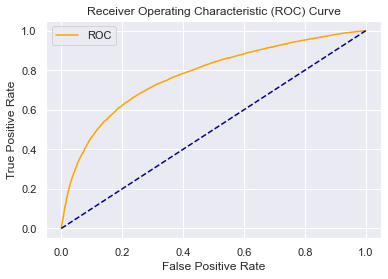

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)

# RESULTS INSIGHT

In [34]:
results_data = x_test
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

,P1,P2,P3,RESULT_TYPE,PROB_PRED,P4,P5,P6,P7,P8,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
266365,12,7,7,None,0.259065,12,12,7,2,6,...,11,11,1,11,3,16,6,11,11,3
165318,9,16,16,None,0.756148,11,1,18,6,17,...,2,7,12,17,12,2,17,12,17,12
48269,7,7,17,None,0.530892,12,7,17,6,6,...,10,15,0,0,15,5,10,0,0,0
89431,6,1,11,None,0.742113,1,11,16,1,6,...,2,6,1,1,6,16,9,4,4,4
4298,2,17,7,None,0.384460,12,2,2,1,1,...,10,15,15,15,10,15,15,15,10,15


In [36]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

,P1,P2,P3,RESULT_TYPE,PROB_PRED,P4,P5,P6,P7,P8,...,P92,P93,P94,P95,P96,P97,P98,P99,P100,P101
266365,12,7,7,FN,0.259065,12,12,7,2,6,...,11,11,1,11,3,16,6,11,11,3
165318,9,16,16,TP,0.756148,11,1,18,6,17,...,2,7,12,17,12,2,17,12,17,12
48269,7,7,17,TP,0.530892,12,7,17,6,6,...,10,15,0,0,15,5,10,0,0,0
89431,6,1,11,TP,0.742113,1,11,16,1,6,...,2,6,1,1,6,16,9,4,4,4
4298,2,17,7,TN,0.384460,12,2,2,1,1,...,10,15,15,15,10,15,15,15,10,15


In [37]:
#Save the results into a file
report_dir="./report"
results_csv_file  =model_name + "_Results.csv"
results_excel_file=model_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

Now, we are going to find the record with highest probability and category TP (True Positive) as a good model of TP data,
and alternatively, the best representative of TN, using the lowest value

In [38]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

rowid best TP = 76727
P1                   11
P2                   16
P3                   11
RESULT_TYPE          TP
PROB_PRED      0.994058
                 ...   
P97                  11
P98                   6
P99                  18
P100                 13
P101                  3
Name: 76727, Length: 103, dtype: object


In [39]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])

rowid best TN = 184761
P1                    7
P2                    7
P3                    2
RESULT_TYPE          TN
PROB_PRED      0.004715
                 ...   
P97                   7
P98                   2
P99                   2
P100                  2
P101                  7
Name: 184761, Length: 103, dtype: object
